# 公共数据

In [1]:
import pandas as pd

In [2]:
df1 = pd.read_excel('dataset/附件一：已结束项目任务数据.xls')
task_location_values = df1[['任务gps经度','任务gps 纬度']].values
task_price_values = df1['任务标价'].values

In [3]:
df2 = pd.read_excel('dataset/附件二：会员信息数据-分列.xlsx')
vip_location_values = df2[['会员位置经度','会员位置纬度']].values
vip_lim_values = df2['预订任务限额'].values
vip_credit_values = df2['信誉值'].values

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']   #解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决中文显示问题

In [5]:
import numpy as np
def get_euclidean_dis(x1, y1, x2, y2):
    x_squ = (x1 - x2)**2
    y_squ = (y1 - y2)**2
    dis = np.sqrt(x_squ + y_squ) * 111 * 1000
    return dis

## 计算得到的数据

### 与城市中心的距离

In [6]:
from sklearn.cluster import KMeans
import numpy as np
cluster = KMeans(n_clusters=4,random_state=0).fit(task_location_values)
y_pred = cluster.labels_
centroid = cluster.cluster_centers_
task_dis_to_city_center = np.zeros(len(df1))
for i in range(len(task_location_values)):
    center_loc = centroid[y_pred[i]]
    task_dis_to_city_center[i] = get_euclidean_dis(task_location_values[i,0],
                                                   task_location_values[i,1],
                                                   center_loc[0],
                                                   center_loc[1])
pd.DataFrame(task_dis_to_city_center).describe()

,0
count,835.000000
mean,17783.392481
std,9654.577805
min,396.992079
25%,11623.089207
50%,16396.632905
75%,22787.597732
max,94366.816502


### 附近任务数

In [7]:
import numpy as np
task_num = len(df1)
task_around_task_count = np.zeros(task_num)
for i in range(task_num):
    for j in range(task_num):
        if i == j:
            continue
        if get_euclidean_dis(task_location_values[i,0],task_location_values[i,1],
                             task_location_values[j,0],task_location_values[j,1],)<=2000:
            task_around_task_count[i] += 1

### 附近会员数及平均完成能力

In [8]:
def entropy_weight(data):
    # 假设data已经正向化过了
    data = np.array(data)
    # 归一化（可能已经归约过了）
    data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
    # 概率矩阵
    p = data / data.sum(axis=0)
    # 信息熵
    E = - np.nansum(p * np.log(np.where(p==0,1,p)), axis=0) / np.log(len(data[0]))
    # 熵权
    return (1 - E) / (1 - E).sum()

In [9]:
vip_lim_credit = np.hstack((vip_lim_values.reshape(-1,1),vip_credit_values.reshape(-1,1)))
vip_cap_w = entropy_weight(vip_lim_credit)
print(vip_cap_w)
vip_lim_credit_con = (vip_lim_credit - vip_lim_credit.min(axis=0)) / (vip_lim_credit.max(axis=0) - vip_lim_credit.min(axis=0))
vip_capbility = (vip_cap_w * vip_lim_credit_con).sum(axis=1)
print(vip_lim_credit_con)
print(vip_capbility)

[0.61346148 0.38653852]
[[4.89177489e-01 1.00000000e+00]
 [7.01298701e-01 5.57764693e-01]
 [5.97402597e-01 4.11089860e-01]
 ...
 [0.00000000e+00 8.97093300e-08]
 [0.00000000e+00 5.14725664e-08]
 [0.00000000e+00 0.00000000e+00]]
[6.86630069e-01 6.45817277e-01 5.25385547e-01 ... 3.46761120e-08
 1.98961298e-08 0.00000000e+00]


In [10]:
import numpy as np
task_num = len(df1)
vip_num = len(df2)
task_around_vip_count = np.zeros(task_num)
task_around_vip_capbility_sum = np.zeros(task_num)
for i in range(task_num):
    for j in range(vip_num):
        if get_euclidean_dis(task_location_values[i,0],task_location_values[i,1],
                             vip_location_values[j,0],vip_location_values[j,1]) <= 2000:
            task_around_vip_count[i] += 1
            task_around_vip_capbility_sum[i] += vip_capbility[i]
task_around_vip_capbility_ave = task_around_vip_capbility_sum / np.where(task_around_vip_count==0,
                                                              1,task_around_vip_count)

# 问题1

## 任务定价规律

### 任务本身的性质：与市中心的距离

#### 聚类划分城市

In [11]:
from sklearn.cluster import KMeans
n_clusters = 4
# 实例化并拟合
cluster = KMeans(n_clusters=n_clusters,random_state=0).fit(task_location_values)
# cluster = AgglomerativeClustering(n_clusters=n_clusters).fit(task_gps_values)
# 此时聚类已经完成了
#重要属性Labels_，查看聚好的类别，每个样本所对应的类
y_pred = cluster.labels_

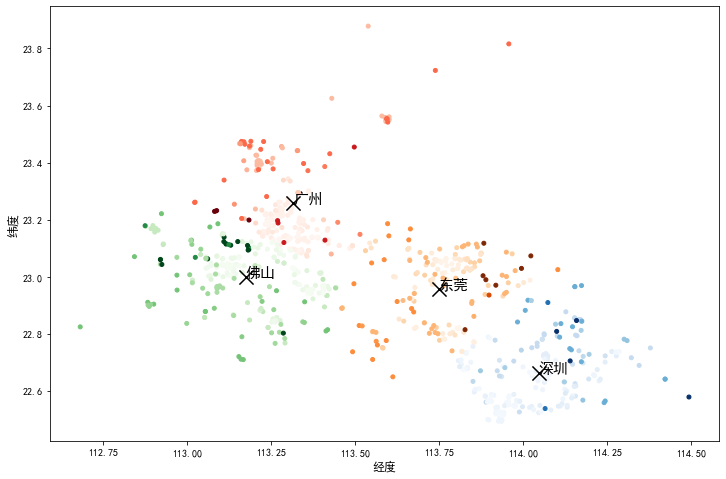

In [12]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
color_map = ["Reds","Blues","Oranges","Greens"]

fig, ax1 = plt.subplots(1)
for i in range(n_clusters):
    ax1.scatter(task_location_values[y_pred==i, 0], task_location_values[y_pred==i, 1]
            ,marker='o' #点的形状
            ,s=16 #点的大小
            ,c=task_price_values[y_pred==i]
            ,cmap=color_map[i]
           )
#重要属性cLuster_centers_，查看质心
centroid = cluster.cluster_centers_
ax1.scatter(centroid[:,0],centroid[:,1]
           ,marker="x"
           ,s=200
           ,c="black")
ax1.text(centroid[0,0], centroid[0,1], '广州', fontsize=15)
ax1.text(centroid[1,0], centroid[1,1], '深圳', fontsize=15)
ax1.text(centroid[2,0], centroid[2,1], '东莞', fontsize=15)
ax1.text(centroid[3,0], centroid[3,1], '佛山', fontsize=15)
ax1.set_xlabel('经度', fontsize=12)
ax1.set_ylabel('纬度', fontsize=12)
fig.set_size_inches(12, 8)
plt.show()

#### 算出距离

In [13]:
import numpy as np
task_dis_to_city_center = np.zeros(len(df1))
for i in range(len(task_location_values)):
    center_loc = centroid[y_pred[i]]
    task_dis_to_city_center[i] = get_euclidean_dis(task_location_values[i,0],
                                                   task_location_values[i,1],
                                                   center_loc[0],
                                                   center_loc[1])
pd.DataFrame(task_dis_to_city_center).describe()

,0
count,835.000000
mean,17783.392481
std,9654.577805
min,396.992079
25%,11623.089207
50%,16396.632905
75%,22787.597732
max,94366.816502


(10000.0, 15000.0]    200
(15000.0, 20000.0]    196
(20000.0, 25000.0]    119
(5000.0, 10000.0]     107
(25000.0, 30000.0]     96
(30000.0, inf]         66
(0.0, 5000.0]          51
Name: 任务距离中心距离所在范围, dtype: int64


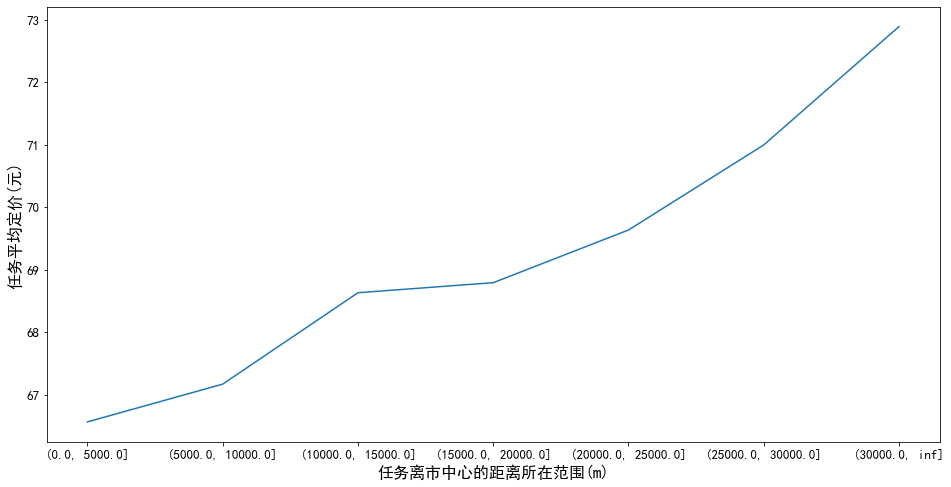

In [14]:
center_dis_price_df = pd.DataFrame({'任务距离中心距离':task_dis_to_city_center, '任务标价':task_price_values})
center_dis_price_df['任务距离中心距离所在范围'] = pd.cut(center_dis_price_df['任务距离中心距离'], [0, 5000, 10000, 15000,20000,25000,30000,np.inf])
print(center_dis_price_df['任务距离中心距离所在范围'].value_counts())
center_dis_price_df.groupby(center_dis_price_df['任务距离中心距离所在范围']).mean()[['任务标价']].plot(figsize=(16, 8),legend=None)
plt.xlabel('任务离市中心的距离所在范围(m)',fontsize=16)
plt.ylabel('任务平均定价(元)',fontsize=16)
plt.tick_params(labelsize=13)

In [15]:
from scipy.stats import jarque_bera, boxcox_normmax
from scipy.special import boxcox1p
max_box = boxcox_normmax(task_dis_to_city_center+1)
task_dis_to_city_center_box = boxcox1p(task_dis_to_city_center,max_box)
jarque_bera(task_dis_to_city_center_box)

Jarque_beraResult(statistic=29.762054800631663, pvalue=3.445497308574019e-07)

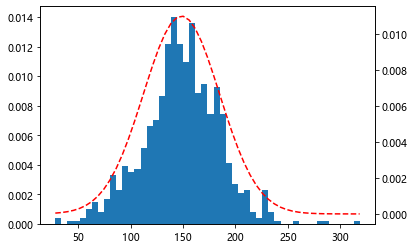

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

plt.figure(1)
task_dis_to_city_center_del = task_dis_to_city_center[task_dis_to_city_center < 50000]
n, bins, patches = plt.hist(task_dis_to_city_center_box,bins=50,density=True)
y = norm.pdf(bins, task_dis_to_city_center_box.mean(), task_dis_to_city_center_box.std())
plt.twinx()
plt.plot(bins, y, 'r--')

In [17]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression as MIR
info = MIR(center_dis_price_df['任务距离中心距离'].values.reshape(-1,1),center_dis_price_df['任务标价'])
info

array([0.31995188])

### 任务之间的影响：周围任务的多少

In [18]:
import numpy as np
task_num = len(df1)
task_around_task_count = np.zeros(task_num)
for i in range(task_num):
    for j in range(task_num):
        if i == j:
            continue
        if get_euclidean_dis(task_location_values[i,0],task_location_values[i,1],
                             task_location_values[j,0],task_location_values[j,1],)<=2000:
            task_around_task_count[i] += 1

(2.0, 4.0]    205
(0.0, 1.0]    144
(1.0, 2.0]    133
(6.0, inf]    119
(4.0, 6.0]    106
Name: 周围任务数所在范围, dtype: int64


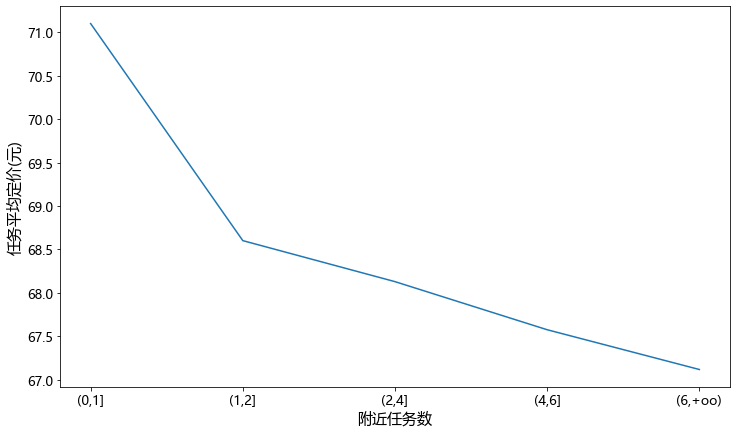

In [19]:
task_count_price_df = pd.DataFrame({'周围任务数':task_around_task_count,'任务标价':task_price_values})
task_count_price_df['周围任务数所在范围'] = pd.cut(task_count_price_df['周围任务数'], [0,1,2,4,6,np.inf])
print(task_count_price_df['周围任务数所在范围'].value_counts())
task_count_price_df.groupby(task_count_price_df['周围任务数所在范围']).mean()['任务标价'].plot(
    figsize=(12, 7),
                                                             legend=False)
plt.xlabel('附近任务数',fontsize=15)
plt.ylabel('任务平均定价(元)',fontsize=15)
plt.xticks(np.linspace(0,4,5),['(0,1]','(1,2]','(2,4]','(4,6]','(6,+oo)'])
plt.tick_params(labelsize=13)

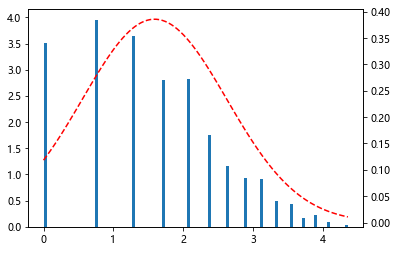

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, boxcox_normmax
from scipy.special import boxcox1p

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

plt.figure(1)
task_around_task_count_box = boxcox1p(task_around_task_count,boxcox_normmax(task_around_task_count+1))
# task_around_task_count_max_sub = task_around_task_count.max() - task_around_task_count
data_for_hist = task_around_task_count_box
n, bins, patches = plt.hist(data_for_hist,bins=100,density=True)
y = norm.pdf(bins, data_for_hist.mean(), data_for_hist.std())
plt.twinx()
plt.plot(bins, y, 'r--')

In [21]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression as MIR
info = MIR(task_count_price_df['周围任务数'].values.reshape(-1,1),center_dis_price_df['任务标价'])
info

array([0.26865472])

### 会员对任务的影响

#### 会员完成能力

In [22]:
def entropy_weight(data):
    # 假设data已经正向化过了
    data = np.array(data)
    # 归一化（可能已经归约过了）
    data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
    # 概率矩阵
    p = data / data.sum(axis=0)
    # 信息熵
    E = - np.nansum(p * np.log(np.where(p==0,1,p)), axis=0) / np.log(len(data[0]))
    # 熵权
    return (1 - E) / (1 - E).sum()

In [23]:
vip_lim_credit = np.hstack((vip_lim_values.reshape(-1,1),vip_credit_values.reshape(-1,1)))
vip_cap_w = entropy_weight(vip_lim_credit)
print(vip_cap_w)
vip_lim_credit_con = (vip_lim_credit - vip_lim_credit.min(axis=0)) / (vip_lim_credit.max(axis=0) - vip_lim_credit.min(axis=0))
vip_capbility = (vip_cap_w * vip_lim_credit_con).sum(axis=1)
print(vip_lim_credit_con)
print(vip_capbility)

[0.61346148 0.38653852]
[[4.89177489e-01 1.00000000e+00]
 [7.01298701e-01 5.57764693e-01]
 [5.97402597e-01 4.11089860e-01]
 ...
 [0.00000000e+00 8.97093300e-08]
 [0.00000000e+00 5.14725664e-08]
 [0.00000000e+00 0.00000000e+00]]
[6.86630069e-01 6.45817277e-01 5.25385547e-01 ... 3.46761120e-08
 1.98961298e-08 0.00000000e+00]


In [24]:
import numpy as np
task_num = len(df1)
vip_num = len(df2)
task_around_vip_count = np.zeros(task_num)
task_around_vip_capbility_sum = np.zeros(task_num)
for i in range(task_num):
    for j in range(vip_num):
        if get_euclidean_dis(task_location_values[i,0],task_location_values[i,1],
                             vip_location_values[j,0],vip_location_values[j,1]) <= 2000:
            task_around_vip_count[i] += 1
            task_around_vip_capbility_sum[i] += vip_capbility[i]
task_around_vip_capbility_ave = task_around_vip_capbility_sum / np.where(task_around_vip_count==0,
                                                              1,task_around_vip_count)

In [25]:
pd.DataFrame(task_around_vip_capbility_ave).describe()

,0
count,835.000000
mean,0.029828
std,0.068023
min,0.000000
25%,0.005425
50%,0.010849
75%,0.026897
max,0.686630


(0.0, 0.0055]     190
(0.025, 0.055]    126
(0.0055, 0.01]    122
(0.01, 0.015]     121
(0.015, 0.025]    112
(0.055, 0.7]       95
Name: 周围会员平均能力所在范围, dtype: int64


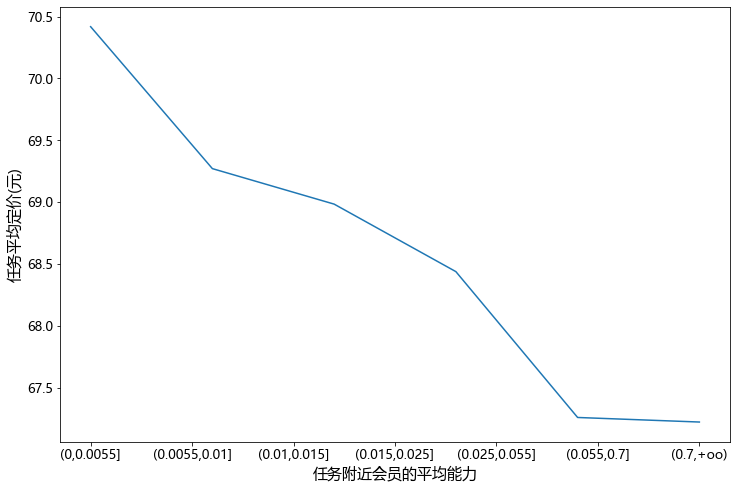

In [26]:
vip_count_price_df = pd.DataFrame({'周围会员平均能力':task_around_vip_capbility_ave, '平均定价':task_price_values})
vip_count_price_df['周围会员平均能力所在范围'] = pd.cut(vip_count_price_df['周围会员平均能力'], 
                                            [0,0.0055,0.01,0.015,0.025,0.055,0.7])
print(vip_count_price_df['周围会员平均能力所在范围'].value_counts())
vip_count_price_df.groupby(vip_count_price_df['周围会员平均能力所在范围']).mean()['平均定价'].plot(
    figsize=(12, 8))
plt.xlabel('任务附近会员的平均能力',fontsize=15)
plt.ylabel('任务平均定价(元)',fontsize=15)
plt.xticks(np.linspace(0,5,7),['(0,0.0055]','(0.0055,0.01]',
                               '(0.01,0.015]','(0.015,0.025]','(0.025,0.055]',
                               '(0.055,0.7]','(0.7,+oo)'])
plt.tick_params(labelsize=13)

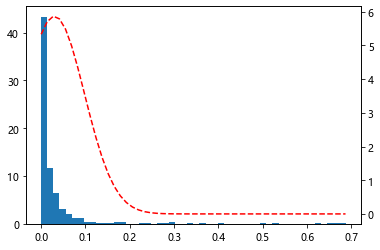

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

plt.figure(1)
task_around_vip_capbility_ave_box = boxcox1p(task_around_vip_capbility_ave,boxcox_normmax(task_around_vip_capbility_ave+1))
n, bins, patches = plt.hist(task_around_vip_capbility_ave,bins=50,density=True)
y = norm.pdf(bins, task_around_vip_capbility_ave.mean(), task_around_vip_capbility_ave.std())
plt.twinx()
plt.plot(bins, y, 'r--')

In [28]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression as MIR
info = MIR(task_around_vip_capbility_ave.reshape(-1,1),task_price_values)
info

array([0.22493361])

#### 周围会员的多少

(2.0, 4.0]     151
(0.0, 1.0]     111
(4.0, 6.0]     111
(6.0, 9.0]     105
(9.0, 15.0]    104
(15.0, inf]     95
(1.0, 2.0]      89
Name: 周围会员数所在范围, dtype: int64


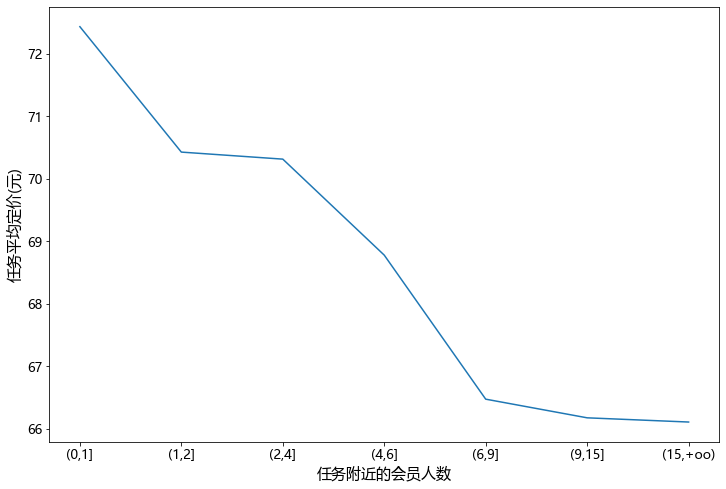

In [29]:
vip_count_price_df = pd.DataFrame({'周围会员数':task_around_vip_count, '平均定价':task_price_values})
vip_count_price_df['周围会员数所在范围'] = pd.cut(vip_count_price_df['周围会员数'], [0,1,2,4,6,9,15,np.inf])
print(vip_count_price_df['周围会员数所在范围'].value_counts())
vip_count_price_df.groupby(vip_count_price_df['周围会员数所在范围']).mean()['平均定价'].plot(
    figsize=(12, 8),)
plt.xlabel('任务附近的会员人数',fontsize=15)
plt.ylabel('任务平均定价(元)',fontsize=15)
plt.xticks(np.linspace(0,6,7),['(0,1]','(1,2]','(2,4]','(4,6]','(6,9]','(9,15]','(15,+oo)'])
plt.tick_params(labelsize=13)

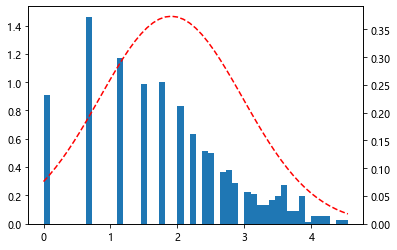

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

plt.figure(1)
max_box = boxcox_normmax(task_around_vip_count+1)
task_around_vip_count_box = boxcox1p(task_around_vip_count,max_box)
n, bins, patches = plt.hist(task_around_vip_count_box,bins=50,density=True)
y = norm.pdf(bins, task_around_vip_count_box.mean(), task_around_vip_count_box.std())
plt.twinx()
plt.plot(bins, y, 'r--')

In [31]:
from sklearn.feature_selection import mutual_info_regression as MIR
info = MIR(task_around_vip_count.reshape(-1,1),task_price_values)
info

array([0.35425315])

### 各汇总影响/回归模型

In [32]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
task_pricefactor = np.array([task_dis_to_city_center,
task_around_task_count,
task_around_vip_count,
task_around_vip_capbility_ave]).T
scaler = StandardScaler()        
task_pricefactor_std = scaler.fit_transform(task_pricefactor)
reg = LR().fit(task_pricefactor_std, task_price_values)
print(reg.coef_)
print(reg.score(task_pricefactor_std, task_price_values))

[ 1.14191507 -0.90630228 -1.20935793 -0.52792703]
0.29010579351496446


In [33]:
pd.DataFrame(reg.coef_)

,0
0,1.141915
1,-0.906302
2,-1.209358
3,-0.527927


In [34]:
from statsmodels.api import OLS, add_constant
OLS(task_price_values, add_constant(task_pricefactor_std)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     84.80
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           2.14e-60
Time:                        16:50:55   Log-Likelihood:                -2299.5
No. Observations:                 835   AIC:                             4609.
Df Residuals:                     830   BIC:                             4633.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.1108      0.132    523.968      0.000      68.852      69.370
x1             1.1419      0.139      8.195      0.000       0.868       1.415
x2            -0.9063      0.145     -6.237      0.000      -1.192      -0.621
x3            -1.2094      0.154     -7.851      0.000      -1.512      -0.907
x4            -0.5279      0.133     -3.957      0.000      -0.790      -0.266
==============================================================================
Omnibus:                      384.728   Durbin-Watson:                   1.451
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1830.404
Skew:                           2.137   Prob(JB):                         0.00
Kurtosis:                       8.861   Cond. No.                         1.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 任务未完成原因